In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import string
import random
import math
import matplotlib.pyplot as plt
import numpy as np

### Select Device

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Define Model

In [65]:
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, nhead, nhid, nlayers, output_dim, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.embed_dim = embed_dim
        self.pos_encoder = PositionalEncoding(embed_dim, dropout)
        self.encoder = nn.Embedding(input_dim, embed_dim)
        self.transformer = nn.Transformer(embed_dim, nhead, nlayers, nlayers, nhid, dropout)
        self.decoder = nn.Linear(embed_dim, output_dim)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, src, src_mask):
        src = src
        src = self.encoder(src) * math.sqrt(self.embed_dim)
        src = self.pos_encoder(src)
        output = self.transformer(src, src, src_mask)
        output = self.decoder(output)
        return output

### Process Data

In [66]:
all_chars = string.printable
n_chars = len(all_chars)
file = open('../Data/shakespeare.txt').read()
file_len = len(file)

In [67]:
def get_random_seq():
    seq_len = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index = start_index + seq_len + 1
    return file[start_index:end_index]

def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), n_chars, dtype=torch.long)
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][index] = 1.0
    return tensor

def seq_to_index(seq):
    tensor = torch.zeros(len(seq), dtype=torch.long)
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

def get_input_and_target():
    seq = get_random_seq()
    input = seq_to_index(seq[:-1])  # Input is represented in index.
    target = seq_to_index(seq[1:])  # Target is represented in index.
    return input, target

def generate_square_subsequent_mask(sz):
    mask = torch.triu(torch.ones(sz, sz) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0)).to(device)
    return mask

### Text Generation

In [68]:
# def generate_text(model, start_seq='W', max_len=100):
#     model.eval()
#     with torch.no_grad():
#         input = seq_to_index(start_seq).unsqueeze(1)  # Shape: (seq_len, batch_size=1)
#         generated = input.to(device)

#         for _ in range(max_len):
#             src_mask = generate_square_subsequent_mask(generated.size(0)).to(device)
#             output = model(generated, src_mask)
            
#             # Select the last time step's output
#             next_char_logits = output[-1, 0, :]
#             next_char = torch.argmax(next_char_logits, dim=-1).unsqueeze(0).unsqueeze(1)  # Shape: (1, 1)
            
#             generated = torch.cat((generated, next_char), dim=0)  # Concatenate along the sequence dimension

#         generated_seq = ''.join([all_chars[idx] for idx in generated.squeeze().tolist()])
#     return generated_seq
# gpt
# def generate_text(model, start_seq='W', max_len=100):
#     predicted_seq = start_seq
# #     model.eval()
# #     with torch.no_grad():
#     init_input = seq_to_index(start_seq).to(device)
#     input = init_input[-1]  # Shape: (seq_len, batch_size=1)
#     for _ in range(max_len):
#         src_mask = generate_square_subsequent_mask(input.size(0)).to(device)
#         output = model(input, src_mask)
#         predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]

#         # Add predicted character to the sequence and use it as next input.
#         predicted_char  = all_chars[predicted_index]
#         predicted_seq  += predicted_char

#         # Use the predicted character to generate the input of next round.
#         input = seq_to_index(predicted_char)[0].to(device)
#     return predicted_seq


# Evaluation step function.
# def generate_text(model, init_seq='W', predicted_len=100):
 
#     init_input    = seq_to_onehot(init_seq).to(device)
#     predicted_seq = init_seq

#     # Set current input as the last character of the initial string.
#     input = init_input[-1]
    
#     # Predict more characters after the initial string.
#     for t in range(predicted_len):
#         src_mask = generate_square_subsequent_mask(input.size(0)).to(device)
#         output = model(input, src_mask)
        
#         # Sample from the output as a multinomial distribution.
#         output = output.view(-1, output_dim)
#         print(output.shape)
#         predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
#         print(predicted_index)
        
#         # Add predicted character to the sequence and use it as next input.
#         predicted_char  = all_chars[predicted_index]
#         predicted_seq  += predicted_char
        
#         # Use the predicted character to generate the input of next round.
#         input = seq_to_onehot(predicted_char)[0].to(device)

#     return predicted_seq

In [69]:
def generate_text(model, start_seq='W', gen_len=100,temperature=1.0):
    model.eval()  # Set the model to evaluation mode
    
    # Convert the starting sequence to indices
#     init_input = seq_to_index(start_seq).unsqueeze(1).to(device)
    input_seq = seq_to_index(start_seq).unsqueeze(1).to(device)  # Add batch dimension, shape: (seq_len, 1)
    
    generated_text = start_seq
    
    for _ in range(gen_len):
        src_mask = generate_square_subsequent_mask(input_seq.size(0)).to(device)
        with torch.no_grad():
            output = model(input_seq, src_mask)
        
        # Get the last output and convert to probabilities
        next_char_logits = output[-1, 0, :] / temperature   # Shape: (output_dim)
        next_char_probs = torch.softmax(next_char_logits, dim=-1)
  
        # Sample the next character
        # predicted_char_index = np.random.choice(len(all_chars), p=next_char_probs)
        # predicted_char_index = np.random.multinomial(len(all_chars),next_char_probs)
        # predicted_char_index = torch.argmax(next_char_probs)
        predicted_char_index = torch.multinomial(next_char_probs, num_samples=1)[0]
        predicted_char = all_chars[predicted_char_index]
        
        generated_text += predicted_char
        
        # Append the next character to the input sequence
        next_char_tensor = torch.tensor([predicted_char_index], dtype=torch.long).unsqueeze(1).to(device)
        input_seq = torch.cat([input_seq, next_char_tensor], dim=0)
    
    return generated_text


## Design choices

I had chat gpt help me write  generate text function. Everything seemed correct except that it wanted to use np.random.choice(len(all_chars), p=next_char_probs) to predict the next char. I instead opted to use softmax and then argmax to select the index of the highest probability. However, I noticed my loss going down and the output generated by the model was not any better. I asked chat gpt with my new implementation and suggested to use torch multinomial as it selects from a probability distribution. Given that we used this approach in class, I went with this approach. 

This stack overflow discussion helped resolve my error with probabilities do not sum to 1: https://stackoverflow.com/questions/46539431/np-random-choice-probabilities-do-not-sum-to-1

In [70]:
input_dim = 512
embed_dim = 128
nhead = 2
nhid = 256
nlayers = 2
output_dim = len(all_chars)
dropout = 0.2

model = TransformerModel(input_dim, embed_dim, nhead, nhid, nlayers, output_dim, dropout)
model.to(device)

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder): Embedding(512, 128)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=256, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDe

### Training Cell

In [71]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# iters = 100
# all_losses = []
# epochs = 40
# for epoch in range(epochs):
#     model.train()
#     total_loss = 0.
#     for _ in range(iters):  # Adjust the number of batches
#         input, target = get_input_and_target()
#         # Add batch dimension, shape: (seq_len, batch_size=1)
#         input = input.unsqueeze(1).to(device)
#         target = target.unsqueeze(1).to(device)
     
#         src_mask = generate_square_subsequent_mask(input.size(0)).to(device)
        
#         optimizer.zero_grad()
#         output = model(input, src_mask)
        
#         # Reshape output to (seq_len * batch_size, output_dim) and target to (seq_len * batch_size)
#         output = output.view(-1, output_dim)
#         target = target.view(-1)
        
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
        
#     all_losses.append(total_loss / iters)
#     print(f'Epoch {epoch+1}, Loss: {total_loss / iters}')
#     print("Generated output:", generate_text(model))

### Training with Scheduler

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=7, gamma=0.1)
iters = 200
all_losses = []
epochs = 40
for epoch in range(epochs):
    model.train()
    total_loss = 0.
    for _ in range(iters):  # Adjust the number of batches
        input, target = get_input_and_target()
        # Add batch dimension, shape: (seq_len, batch_size=1)
        input = input.unsqueeze(1).to(device)
        target = target.unsqueeze(1).to(device)
     
        src_mask = generate_square_subsequent_mask(input.size(0)).to(device)
        
        optimizer.zero_grad()
        output = model(input, src_mask)
        
        # Reshape output to (seq_len * batch_size, output_dim) and target to (seq_len * batch_size)
        output = output.view(-1, output_dim)
        target = target.view(-1)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    all_losses.append(total_loss / iters)
    print(f'Epoch {epoch+1}, Loss: {total_loss / iters}')
    print("Generated output:", generate_text(model))
    exp_lr_scheduler.step()

Epoch 1, Loss: 3.056742306947708
Generated output: Wnde ilof s otouky th or I

_LOETulous:
TUWhas,
OCisofosis he  af ar paly s fouls
ASoficlniare or al 
Epoch 2, Loss: 2.6466616547107695
Generated output: Wou myoutaisoano odfe avere at therouind sinound S n prirerve:
Gounggonison neatha ouriniakofie loutr
Epoch 3, Loss: 2.589185825586319
Generated output: WA:
K:N:,
DIUIREI te ar y T: ICA:
'bakn,
 sove bthar beple, thetomendisil b,

LELI O che, ce k he se 
Epoch 4, Loss: 2.544263023138046
Generated output: With l c or echas
HerelI th n FI mes youe
Itoucus hy mus y nt bulait, s abe
Y:
?


UCPUS:
NGDou I t n
Epoch 5, Loss: 2.4292625427246093
Generated output: WIIwIw ww,
E:
.


NER:
RUKIU:
I.

A:

MIORIOES:

I.
HIs c.



OLOLO.



BER:
MEEROLURO:
NIURLIIS:
H.

Epoch 6, Loss: 1.9610467201471329
Generated output: W
WALIRIOM

K?

CHERDORLEORHYDDVERY:
CRYSCHSRC+

CPUS:
YCv.
WRDCFHM
D:
GxI WILIOOSSERRCHOMLERIO:MENRY
Epoch 7, Loss: 1.2456202119588853
Generated output: W W Ww,,,,,,,,!!!,,,,!,w,!I

### Reason for Step

Noticing that the loss decreased, but text quality decreased, I asked chat-gpt. Could potentially be due to overfitting, so it suggested adding a step scheduler

Used this link to implement step: https://discuss.pytorch.org/t/what-does-scheduler-step-do/47764

### Loss Curve

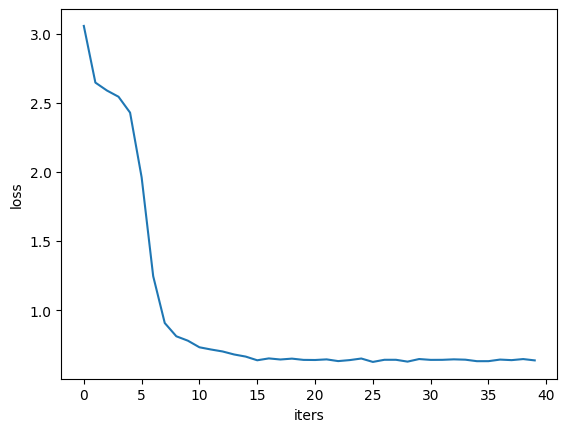

In [73]:
plt.xlabel('iters')
plt.ylabel('loss')
all_losses = [loss for loss in all_losses]
plt.plot(np.array(all_losses))
plt.show()

In [74]:
rand_input = get_random_seq() 
print("Input\n",rand_input)
print("Output")
print(generate_text(model, rand_input))

Input
 so shriek abroad?

LADY CAPULET:
The people in the street cry Romeo,
Some Juliet, and some Paris; and all run,
With open outcry t
Output
so shriek abroad?

LADY CAPULET:
The people in the street cry Romeo,
Some Juliet, and some Paris; and all run,
With open outcry t, wioutht lye t toust ise thoun, athou. t the pnopo t nt un, tout y yon My, jureny gel to pounom, nt
